In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tqdm.notebook as tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

2024-05-15 21:37:35.863861: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 21:37:35.867569: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 21:37:35.908527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 21:37:36.597533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
df_train = pd.read_csv('minor_project/FairFace/train_labels.csv')
df_train['split'] = 'train'
df_train['file'] = 'minor_project/FairFace/' + df_train.file
df_test = pd.read_csv('minor_project/FairFace/val_labels.csv')
df_test['file'] = 'minor_project/FairFace/' + df_test.file
df_test['split'] = 'test'
df = pd.concat([df_train, df_test])

df.gender, labels_map = pd.Categorical(df.gender).factorize()

df = df.drop(columns=['service_test', 'race', 'age'])

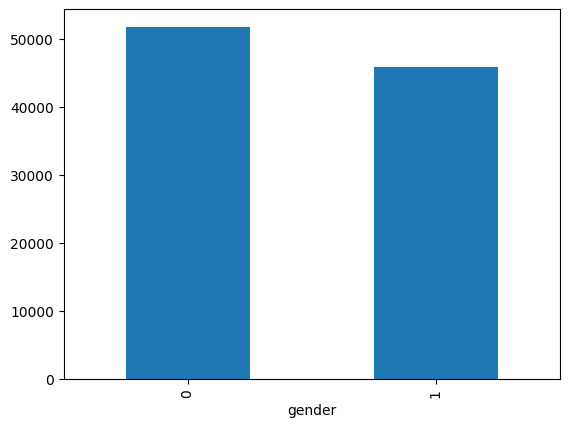

In [7]:
df['gender'].value_counts().plot.bar()
plt.show()
plt.close()

In [8]:
df_train = df[df.split == 'train'].drop(columns=['split'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=0, shuffle=True)
df_test = df[df.split == 'test'].drop(columns=['split'])

In [5]:
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Model

# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')

# for layer in base_model.layers:
#     layer.trainable = False

# base = Dense(2, activation='softmax')(base_model.output)
# model = Model(base_model.input, base)
# model.compile(loss='categorical_crossentropy',
#              optimizer=SGD(learning_rate=0.1, momentum=0.9, decay=0.5), 
#              metrics=['accuracy'])

2024-05-15 21:42:06.822319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


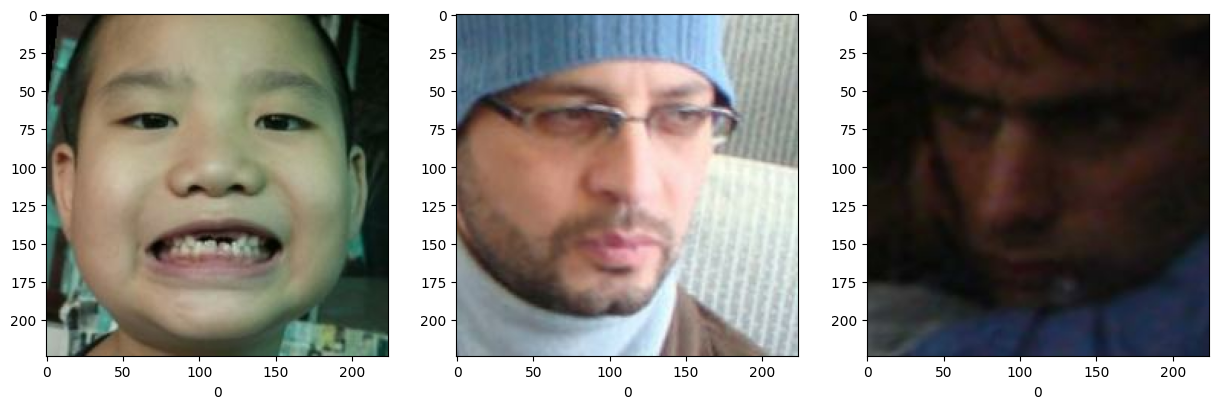

In [9]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 224
NUM_CLASSES = len(labels_map)

# Dataset creation
y_train = tf.keras.utils.to_categorical(df_train.gender, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(df_test.gender, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(df_val.gender, num_classes=NUM_CLASSES)


train_ds = tf.data.Dataset.from_tensor_slices((df_train.file, y_train)).shuffle(len(y_train))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.file, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.file, y_test))

assert len(train_ds) == len(df_train.file) == len(df_train.gender)
assert len(val_ds) == len(df_val.file) == len(df_val.gender)
assert len(test_ds) == len(df_test.file) == len(df_test.gender)

# Read files
def map_fn(path, label):
    image = tf.io.decode_jpeg(tf.io.read_file(path))
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Read files
train_ds = train_ds.map(lambda path, lbl: (tf.io.decode_jpeg(tf.io.read_file(path)), lbl), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda path, lbl: (tf.io.decode_jpeg(tf.io.read_file(path)), lbl), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda path, lbl: (tf.io.decode_jpeg(tf.io.read_file(path)), lbl), num_parallel_calls=AUTOTUNE)

# Batch and resize after batch, then prefetch
train_ds = train_ds.map(lambda imgs, lbls: (tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE)), lbls), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda imgs, lbls: (tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE)), lbls), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda imgs, lbls: (tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE)), lbls), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Performance enchancement - cache, batch, prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Display some
imgs, lbls = list(train_ds.take(1))[0]
n = 3
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
for i, (img, lbl) in enumerate(zip(imgs[:n], lbls[:n])):
    ax[i].imshow(img.numpy().astype('uint8'))
    ax[i].set(xlabel=lbl.numpy().argmax())

plt.show()

In [10]:
print(NUM_CLASSES)

2


In [11]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([tf.keras.layers.Lambda(lambda x: x)])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg"
)

base_model.trainable = False


In [12]:
LEARNING_RATE = 0.001

inputs = x = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=NUM_CLASSES, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

model.compile(
    optimizer=tf.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
EPOCHS = 15

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_delta=0.0001),
    tf.keras.callbacks.ModelCheckpoint(
        'weights.weights.h5',  # Update filepath to end with .weights.h5
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=15, verbose=1, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    callbacks=callbacks,
    epochs=EPOCHS,
)

# model.load_weights('weights.h5')

model.evaluate(test_ds)

Epoch 1/15


I0000 00:00:1715834574.827516  163733 service.cc:145] XLA service 0x7e4ca00066b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715834574.827561  163733 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1715834574.952571  163733 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6763 - loss: 0.6097
Epoch 1: val_loss improved from inf to 0.52847, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 695s 2s/step - accuracy: 0.6764 - loss: 0.6096 - val_accuracy: 0.7366 - val_loss: 0.5285 - learning_rate: 0.0010
Epoch 2/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7387 - loss: 0.5233
Epoch 2: val_loss improved from 0.52847 to 0.51661, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.7387 - loss: 0.5233 - val_accuracy: 0.7409 - val_loss: 0.5166 - learning_rate: 0.0010
Epoch 3/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7425 - loss: 0.5145
Epoch 3: val_loss improved from 0.51661 to 0.50649, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.7425 - loss: 0.5145 - val_accuracy: 0.7489 - val_loss: 0.5065 - learning_rate: 0.0010
Epoch 4/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7460 - l

[0.4942035973072052, 0.7584444284439087]

In [14]:
y_true, y_pred = [], []
for imgs, lbls in test_ds.take(len(test_ds)):
    y_true.append(lbls.numpy())
    y_pred.append(model.predict(imgs))

y_pred = np.argmax(np.concatenate(y_pred), axis=1) 
y_true = np.argmax(np.concatenate(y_true), axis=1)   

print(cr(y_pred=y_pred, y_true=y_true))
print(cm(y_pred=y_pred, y_true=y_true))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

2024-05-16 00:40:18.568128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


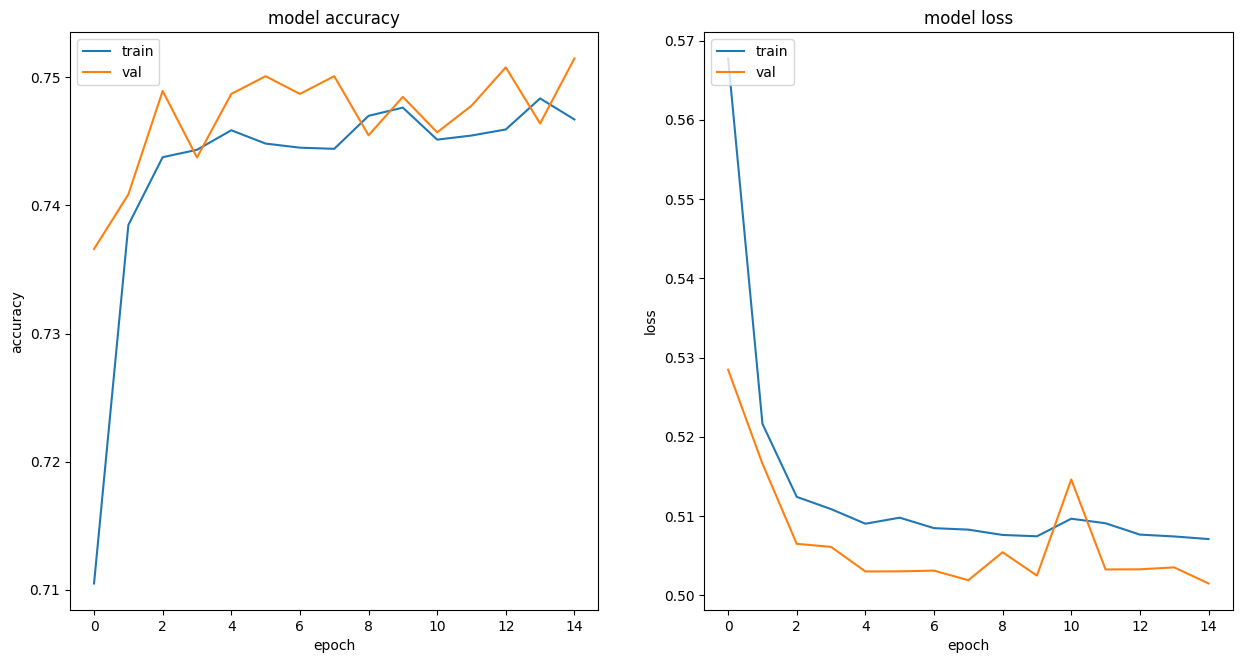

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(ylabel='accuracy', xlabel='epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(ylabel='loss', xlabel='epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
FINE_TUNE_EPOCHS = 5

base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 35
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(
    optimizer=tf.optimizers.Adam(LEARNING_RATE / 10),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_delta=0.0001),
    tf.keras.callbacks.ModelCheckpoint(
        'weights.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=15, verbose=1, restore_best_weights=True)
]


history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1]+FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks,
    verbose=1,
)

# model.save_weights('weights_fine.tf')

model.evaluate(test_ds)


Number of layers in the base model:  155


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,200,706 (8.40 MB)

 Non-trainable params: 59,840 (233.75 KB)

None
Epoch 15/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7698 - loss: 0.4681
Epoch 15: val_loss improved from inf to 0.68240, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 1717s 5s/step - accuracy: 0.7699 - loss: 0.4678 - val_accuracy: 0.8093 - val_loss: 0.6824 - learning_rate: 1.0000e-04
Epoch 16/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9126 - loss: 0.2049
Epoch 16: val_loss did not improve from 0.68240
349/349 ━━━━━━━━━━━━━━━━━━━━ 1682s 5s/step - accuracy: 0.9126 - loss: 0.2049 - val_accuracy: 0.8045 - val_loss: 0.7751 - learning_rate: 1.0000e-04
Epoch 17/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9536 - loss: 0.1188
Epoch 17: val_loss did not improve from 0.68240
349/349 ━━━━━━━━━━━━━━━━━━━━ 1682s 5s/step - accuracy: 0.9536 - loss: 0.1188 - val_accuracy: 0.7969 - val_loss: 0.9667 - learning_rate: 1.0000e-04
Epoch 18/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9820 - loss: 0.0552
Epoch 18: val_loss improved fr

[0.448775053024292, 0.8704583048820496]

In [17]:
y_true, y_pred = [], []
for imgs, lbls in test_ds.take(len(test_ds)):
    y_true.append(lbls.numpy())
    y_pred.append(model.predict(imgs))

y_pred = np.argmax(np.concatenate(y_pred), axis=1) 
y_true = np.argmax(np.concatenate(y_true), axis=1)   

print(cr(y_pred=y_pred, y_true=y_true))
print(cm(y_pred=y_pred, y_true=y_true))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

2024-05-16 03:10:43.413854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


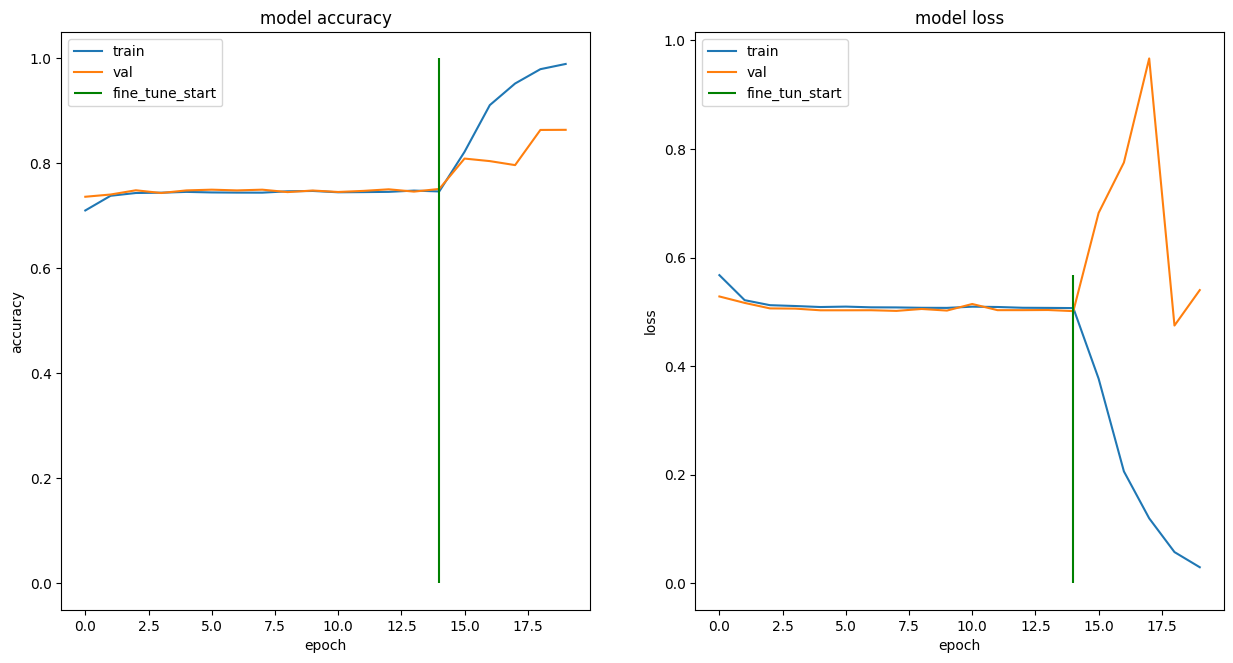

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

ax1.plot(acc)
ax1.plot(val_acc)
ax1.set_title('model accuracy')
ax1.set(ylabel='accuracy', xlabel='epoch')
ax1.vlines(history.epoch[-1], 0, 1, colors='green')
ax1.legend(['train', 'val', 'fine_tune_start'], loc='upper left')


ax2.plot(loss)
ax2.plot(val_loss)
ax2.set_title('model loss')
ax2.set(ylabel='loss', xlabel='epoch')
ax2.vlines(history.epoch[-1], 0, max(loss), colors='green')
ax2.legend(['train', 'val', 'fine_tun_start'], loc='upper left')

plt.show()

In [2]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


2024-05-16 03:10:56.821660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


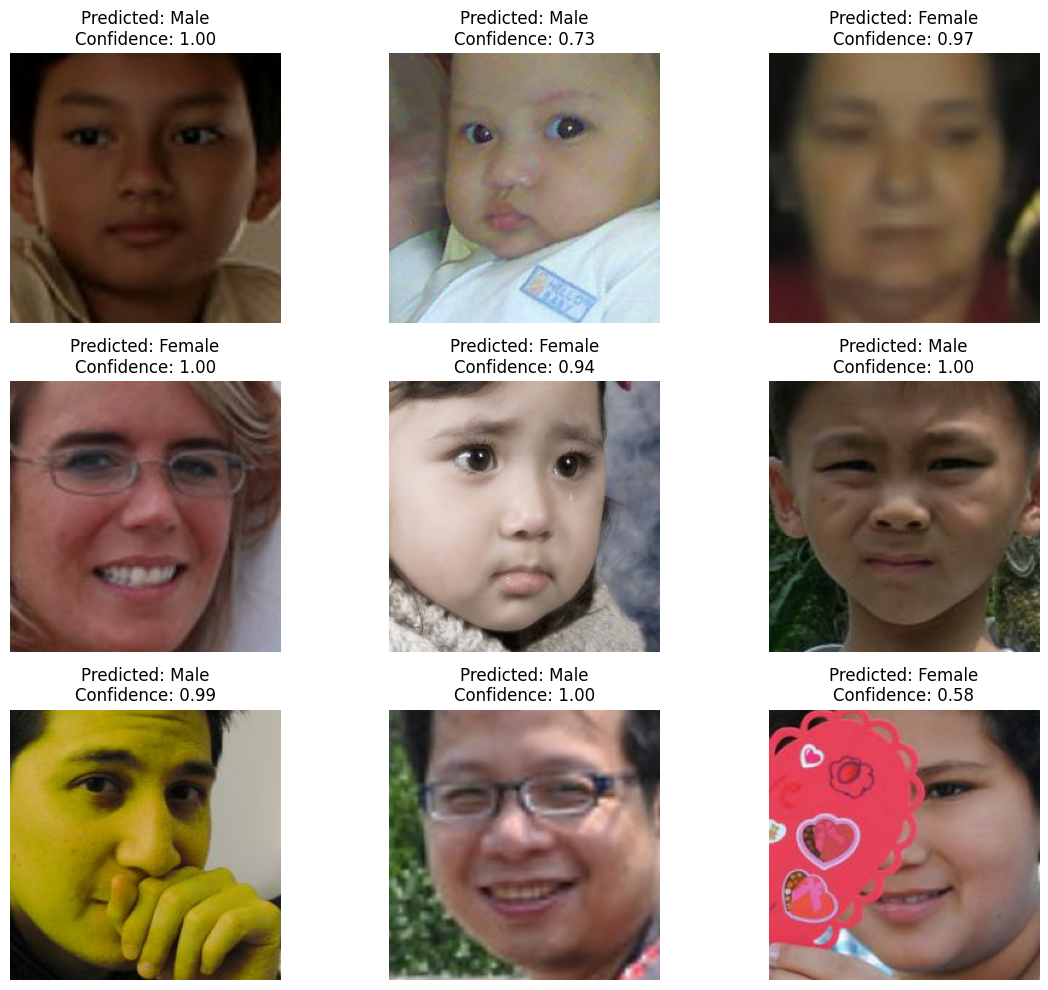

In [19]:
def display_images_with_predictions(model, val_ds, num_images=9):
    class_labels = {0: "Male", 1: "Female"}

    plt.figure(figsize=(12, 10))
    for i, (imgs, lbls) in enumerate(val_ds.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[0].numpy().astype("uint8"))  # Assuming the batch size is 1
        plt.axis('off')
        prediction = model.predict(imgs)[0]
        predicted_label_idx = np.argmax(prediction)
        confidence = prediction[predicted_label_idx]
        predicted_label = class_labels[predicted_label_idx]
        plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.tight_layout()
    plt.show()

# Call the function to display images with predictions
display_images_with_predictions(model, test_ds)